# Organizing observations for a list of nearby SNe

`Author: Francisco Förster, Last update: 20210407`

In this example we will query for a sample of young SN candidates located near the galaxies of a catalog of nearby galaxies, query a sample of SNe recently detected, and use our forecasting tool to organize observations in a given night.

Under construction...

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os, sys, re

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [4]:
import psycopg2

In [5]:
from alerce.core import Alerce
alerce = Alerce()

In [6]:
from scipy.interpolate import interp1d

# Morphologically classified catalog (Ann & Seo 2015)

https://arxiv.org/pdf/1502.03545.pdf

In [10]:
gal_morph = pd.read_csv("https://github.com/alercebroker/usecases/blob/master/example_data/MorphGal.dat?raw=true", sep="\s+")
gal_morph.head()

,objid,ra,dec,z,Morph,T,Distance,rMag,umr,amaj,b_a,name
0,587730773888860441,0.264999,14.580184,0.005718,Im/BCD,12,25.27,-15.03,0.59,25.9,0.68,SDSSJ000103.59+143448.6
1,587727223561388187,0.812671,16.145773,0.003516,SAa,1,16.47,-19.92,3.42,342.5,0.30,NGC7814
2,587727222487646439,0.929659,15.217976,0.002929,SAdm,8,14.13,-15.67,1.93,90.5,0.51,UGC00017
3,587727223025106954,2.193413,15.815708,0.002885,Im,10,13.94,-17.81,1.33,97.4,0.84,NGC0014
4,587727220877623551,2.203321,14.033716,0.006300,Sm/Im,10,27.56,-15.14,1.44,48.2,0.27,SDSSJ000848.74+140204.0


# Perform a query for young SNe within two semimajor axis of one of the previous nearby galaxies|

Load credentials

In [11]:
import requests
# use the location of your credentials file here
credentials_file = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(credentials_file).json()["params"]

In [12]:
conn = psycopg2.connect(dbname=params["dbname"], user=params["user"], host=params["host"], password=params["password"])

Build a string with the galaxy names and coordinates

In [13]:
gal_str = ",\n".join(gal_morph.loc[gal_morph.amaj > 60].apply(lambda row: "(%s, %s, %s, %s)" % (row.name, row.ra, row.dec, row.amaj), axis=1).values) # note that index is called as row.name, the name column should be called row["name"]

In [14]:
from astropy.time import Time
nt = Time.now()
first_mjd_discovery = Time("2021-03-01").mjd
last_mjd_discovery = Time("2021-04-01").mjd
ndetmin = 5
search_radius = 2. * gal_morph.amaj.max() / 3600 # degrees

In [15]:
query = """
WITH catalog ( gal_id, ra, dec, amaj) AS (
    VALUES
        {values}
),
sn (oid, classifier_name, classifier_version, class_name, probability, ranking) AS (
    SELECT
        o.oid, p.classifier_name, p.classifier_version, p.class_name, p.probability, p.ranking
    FROM
        probability p
    INNER JOIN 
        object o
    ON 
        o.oid=p.oid
    WHERE
        p.classifier_name='stamp_classifier'
        AND classifier_version='stamp_classifier_1.0.4' -- This version is active since March 2021
        AND p.class_name IN ('SN')
        AND p.ranking=1
        AND p.probability > 0.4
        AND o.firstmjd > {first_mjd_discovery}
        AND o.firstmjd < {last_mjd_discovery}
        AND o.ndet > {ndetmin}
)

SELECT 
    c.gal_id, c.ra, c.dec, c.amaj, o.oid, o.meanra, o.meandec, q3c_dist(c.ra,c.dec,o.meanra,o.meandec), 
    o.firstmjd, sn.classifier_name, sn.class_name, sn.classifier_version, sn.probability, sn.ranking

FROM object o INNER JOIN sn ON sn.oid=o.oid, catalog c
    /*
     * It is REALLY important to first use the catalog then the object ra,dec for speed. The radius is in degrees.
     */
WHERE
    q3c_join(c.ra, c.dec,o.meanra, o.meandec, {radius})
    AND q3c_dist(c.ra,c.dec,o.meanra,o.meandec) < (2 * c.amaj / 3600)
ORDER BY
    c.gal_id
""" 

query_str = query.format(values=gal_str, radius=search_radius, 
                         first_mjd_discovery = first_mjd_discovery,
                         last_mjd_discovery = last_mjd_discovery,
                         ndetmin=ndetmin) # radius in degrees

~10 seconds

In [19]:
matches = pd.read_sql(query_str,conn)

We will inherit some columns from the catalog dataframe

In [20]:
matches["q3c_dist"] = matches.q3c_dist * 3600
for key in ["z", "Distance", "name", "Morph"]:
    matches[key] = gal_morph.loc[matches.gal_id][key].values
print(matches.shape)
matches

(6, 18)


,gal_id,ra,dec,amaj,oid,meanra,meandec,q3c_dist,firstmjd,classifier_name,class_name,classifier_version,probability,ranking,z,Distance,name,Morph
0,1252,159.691056,53.503378,183.9,ZTF21aaqgmjt,159.696986,53.508428,22.174875,59293.242107,stamp_classifier,SN,stamp_classifier_1.0.4,0.855460,1,0.003309,10.66,NGC3310,SAcd
1,2453,181.763038,43.065663,205.2,ZTF21aanzcuj,181.771810,42.988432,278.990239,59278.312535,stamp_classifier,SN,stamp_classifier_1.0.4,0.697352,1,0.002692,8.34,NGC4111,SA0
2,2584,183.049144,13.246514,110.4,ZTF21aaqhhfu,183.042902,13.249179,23.883678,59293.235347,stamp_classifier,SN,stamp_classifier_1.0.4,0.757625,1,0.006211,16.67,NGC4165,SABa
3,2589,183.071942,13.205199,186.9,ZTF21aaqhhfu,183.042902,13.249179,188.215303,59293.235347,stamp_classifier,SN,stamp_classifier_1.0.4,0.757625,1,0.007725,28.44,NGC4168,E
4,3196,186.427333,7.216654,282.9,ZTF21aaqytjr,186.423654,7.228400,44.280519,59303.358900,stamp_classifier,SN,stamp_classifier_1.0.4,0.783118,1,0.003322,16.67,IC3322A,Scd
5,5356,226.623464,55.763645,443.6,ZTF21aasqxqw,226.837720,55.766481,434.055442,59291.494676,stamp_classifier,SN,stamp_classifier_1.0.4,0.434446,1,0.002242,7.83,NGC5866,SAB0


And we will show the available candidates in the ALeRCE explorer. You will see a list of candidates, once you click on one, you can move between candidates using the keyboard arrows :)

In [23]:
url = "https://alerce.online/?" + "&".join(["oid=%s" % oid for oid in matches.iloc[:100].oid.values]) + "&count=true&page=1&perPage=1000&sortDesc=false"
print(url)

https://alerce.online/?oid=ZTF21aaqgmjt&oid=ZTF21aanzcuj&oid=ZTF21aaqhhfu&oid=ZTF21aaqhhfu&oid=ZTF21aaqytjr&oid=ZTF21aasqxqw&count=true&page=1&perPage=1000&sortDesc=false


# Now we will do forecast over supernova candidates discovered during February and with at least 20 detections in order to plan some observations

We now do a simpler query based on the light curve classifier probabilities and the number of detections required.

In [24]:
query = """
SELECT
    o.oid, o.ndet, o.meanra, o.meandec, p.classifier_name, p.classifier_version, p.class_name, p.probability, p.ranking
FROM
    probability p
INNER JOIN 
    object o
ON 
    o.oid=p.oid
WHERE
    p.classifier_name='lc_classifier'
    AND p.class_name IN ('SNIa', 'SNIbc', 'SNII', 'SLSN')
    AND ranking=1
    AND p.probability > 0.45
    AND o.firstmjd > {first_mjd_discovery}
    AND o.firstmjd < {last_mjd_discovery}
    AND o.ndet > {ndetmin}
ORDER BY
    p.probability DESC
""" 
#    AND q3c_dist(c.ra,c.dec,o.meanra,o.meandec) < (amaj / 3600)
#        AND p.class_name IN ('SN')

query_str = query.format(first_mjd_discovery = Time("2021-02-01").mjd,
                         last_mjd_discovery = Time("2021-03-01").mjd,
                         ndetmin=20) # radius in degrees

In [28]:
matches = pd.read_sql(query_str,conn)

In [29]:
matches

,oid,ndet,meanra,meandec,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF21aakzmaq,27,129.871322,-1.408095,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.513936,1
1,ZTF21aagolqa,32,158.071278,43.659177,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.501984,1
2,ZTF21aalnyny,28,217.841755,55.763218,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.499000,1
3,ZTF21aajdbhw,23,124.553787,10.890231,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.493012,1
4,ZTF21aaglylh,29,100.521413,51.927215,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.487024,1
5,ZTF21aagtceu,22,219.663325,52.584621,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.481036,1
6,ZTF21aalgszc,52,162.600633,0.926911,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.480072,1
7,ZTF21aakyrok,22,114.159028,39.763513,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.479108,1
8,ZTF21aahccrk,26,130.014578,53.122845,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.478080,1
9,ZTF21aalenaa,27,137.177844,13.103601,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.477224,1


Let's look at the results in the ALeRCE explorer!

In [30]:
url = "https://alerce.online/?" + "&".join(["oid=%s" % oid for oid in matches.oid.values]) + "&count=true&page=1&perPage=1000&sortDesc=false"
print(url)

https://alerce.online/?oid=ZTF21aakzmaq&oid=ZTF21aagolqa&oid=ZTF21aalnyny&oid=ZTF21aajdbhw&oid=ZTF21aaglylh&oid=ZTF21aagtceu&oid=ZTF21aalgszc&oid=ZTF21aakyrok&oid=ZTF21aahccrk&oid=ZTF21aalenaa&oid=ZTF21aalhtgv&oid=ZTF21aagxmcs&oid=ZTF21aagtoic&oid=ZTF21aagtexi&oid=ZTF21aagtpyw&oid=ZTF21aagmqic&oid=ZTF21aahvuvi&oid=ZTF21aanortq&oid=ZTF21aagrhot&oid=ZTF21aagxmfv&oid=ZTF21aagyscx&oid=ZTF21aalyubu&oid=ZTF21aalyvyw&oid=ZTF21aagtqug&oid=ZTF21aamwzfi&oid=ZTF21aahvksh&oid=ZTF21aahfjlo&oid=ZTF21aamjsrb&oid=ZTF21aaiwlyy&count=true&page=1&perPage=1000&sortDesc=false


# Let's use the ALeRCE forecast API to do forecasting over the previous sample

In [31]:
def get_forecasts(oid, times):
    print("Getting forecasts for %s..." % oid)
    forecasts = []
    url = "https://api.alerce.online/forecast/v1/parametric/sn?oid=%s&%s" % (oid, "&".join(["mjd=%s" % mjd for mjd in times]))
    response = requests.get(url)
    return pd.DataFrame(response.json()["forecast"]).apply(pd.Series.explode)

And let's write a function to plot the observed vs forecasted data

In [32]:
def plot_SN(oid, det, non_det, pred):
    fig, ax = plt.subplots()
    colors = {1: 'g', 2: 'r'}
    for fid in det.fid.unique():
        mask = det.fid == fid
        ax.errorbar(det.loc[mask].mjd, det.loc[mask].magpsf, yerr=det.loc[mask].sigmapsf, c=colors[fid], marker='o', lw=0, elinewidth=1)
        mask_f = pred.fid == fid
        ax.plot(pred.loc[mask_f].mjd.values, np.array(pred.loc[mask_f].magpsf.values), c=colors[fid], ls=":")
    if not non_det.empty:
        for fid in non_det.fid.unique():
            mask = non_det.fid == fid
            ax.scatter(non_det.loc[mask].mjd, non_det.loc[mask].diffmaglim, c=colors[fid], marker='v', alpha=0.3)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel("MJD")
    ax.set_ylabel("mag")
    ax.set_title(oid)
    plt.show()
    plt.close()

Now we will iterate over the previous SNe to see how the forecasting is doing. We will build interpolating funcitons for every object and filter, stored in the dictionary `snpred[oid][fid]`

Getting forecasts for ZTF21aakzmaq...


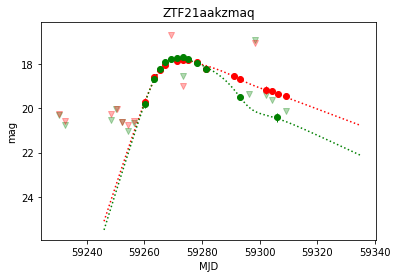

Getting forecasts for ZTF21aagolqa...


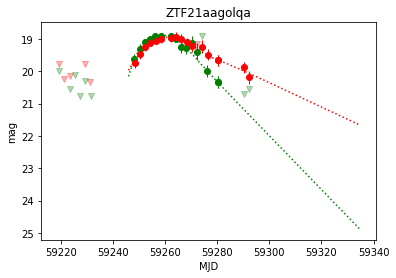

Getting forecasts for ZTF21aalnyny...


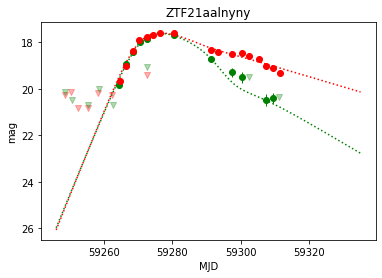

Getting forecasts for ZTF21aajdbhw...


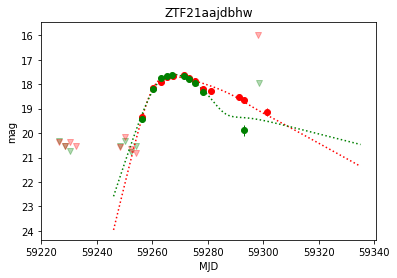

Getting forecasts for ZTF21aaglylh...


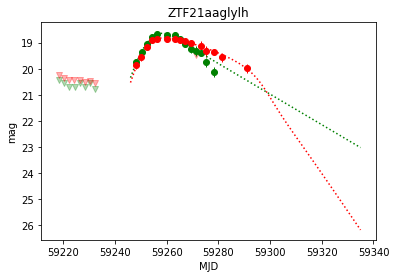

Getting forecasts for ZTF21aagtceu...


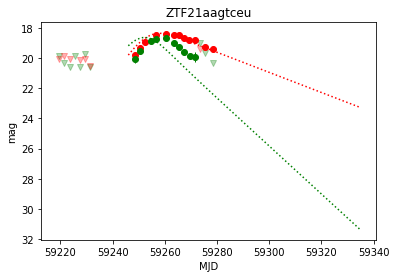

Getting forecasts for ZTF21aalgszc...


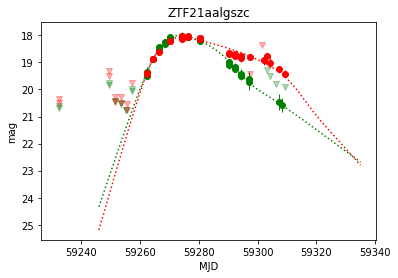

Getting forecasts for ZTF21aakyrok...


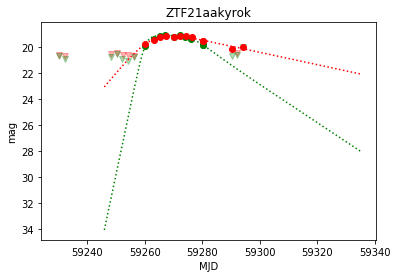

Getting forecasts for ZTF21aahccrk...


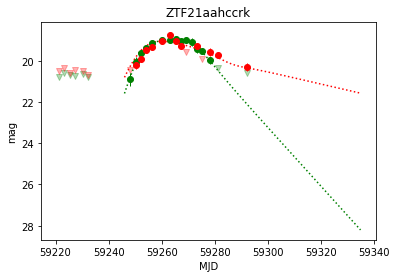

Getting forecasts for ZTF21aalenaa...


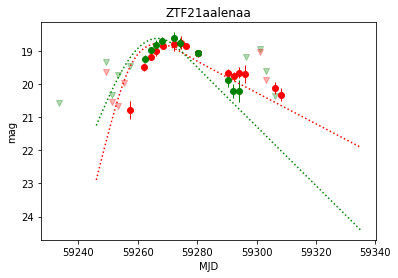

Getting forecasts for ZTF21aalhtgv...


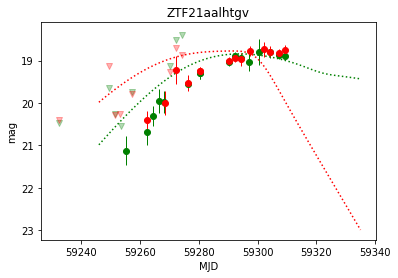

Getting forecasts for ZTF21aagxmcs...


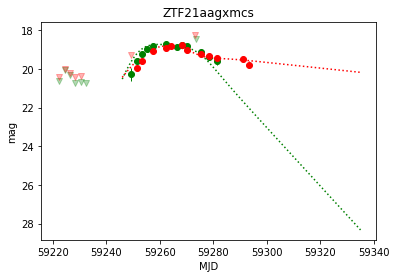

Getting forecasts for ZTF21aagtoic...


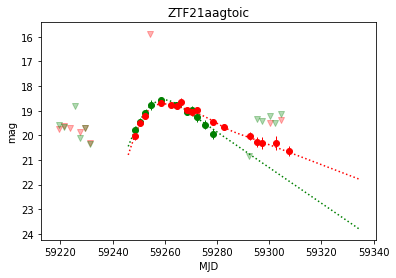

Getting forecasts for ZTF21aagtexi...


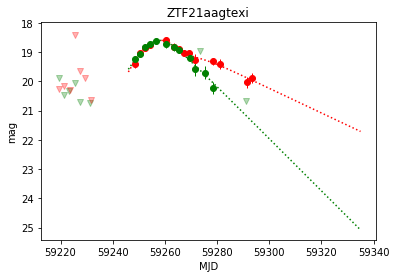

Getting forecasts for ZTF21aagtpyw...


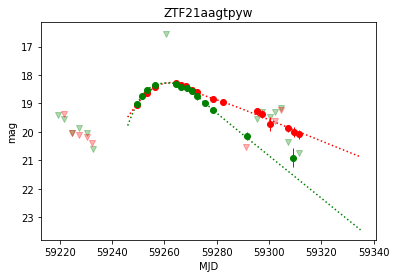

Getting forecasts for ZTF21aagmqic...


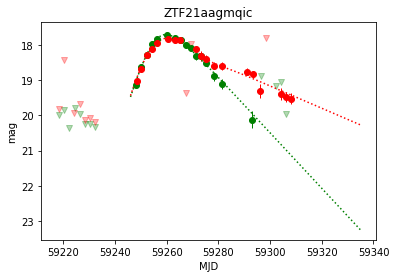

Getting forecasts for ZTF21aahvuvi...


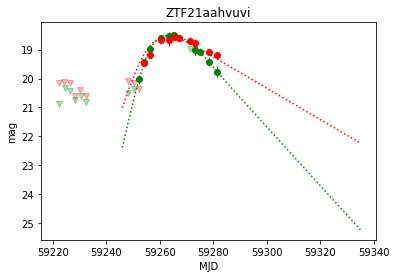

Getting forecasts for ZTF21aanortq...


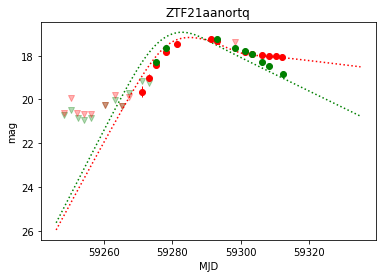

Getting forecasts for ZTF21aagrhot...


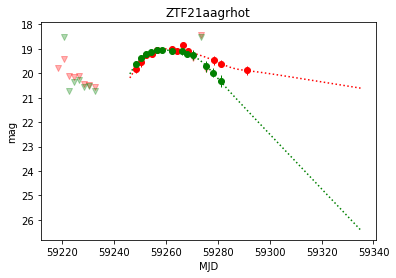

Getting forecasts for ZTF21aagxmfv...


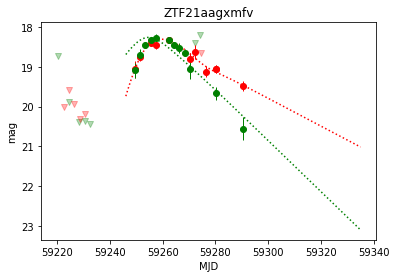

Getting forecasts for ZTF21aagyscx...


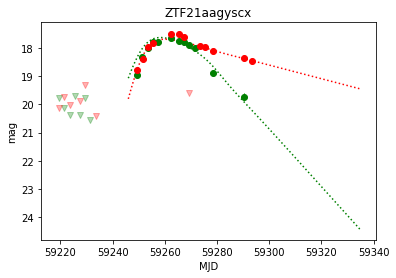

Getting forecasts for ZTF21aalyubu...


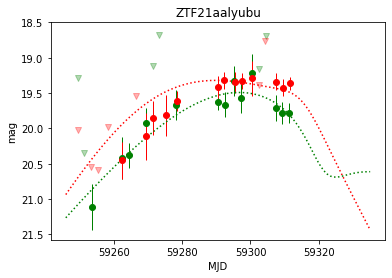

Getting forecasts for ZTF21aalyvyw...


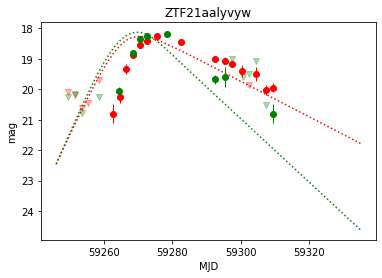

Getting forecasts for ZTF21aagtqug...


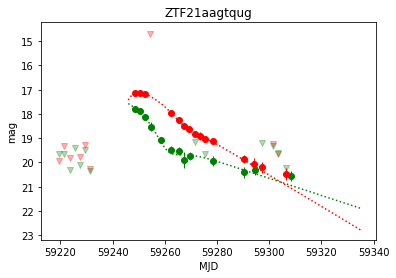

Getting forecasts for ZTF21aamwzfi...


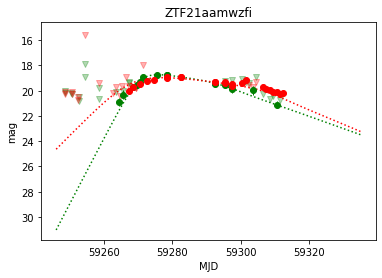

Getting forecasts for ZTF21aahvksh...


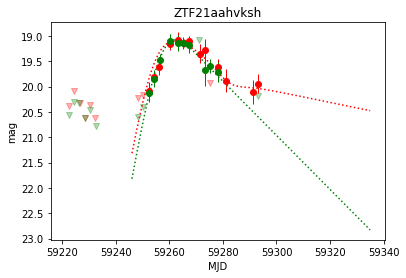

Getting forecasts for ZTF21aahfjlo...


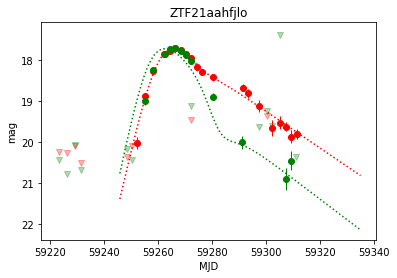

Getting forecasts for ZTF21aamjsrb...


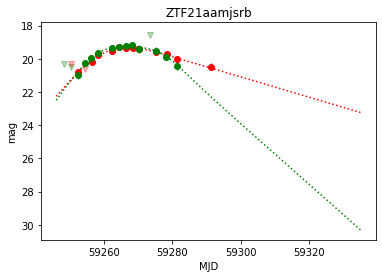

Getting forecasts for ZTF21aaiwlyy...


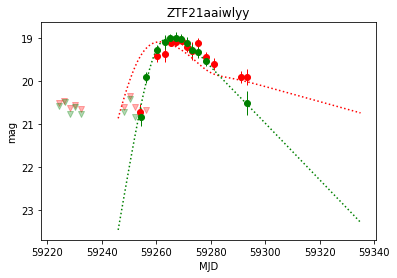

In [33]:
times = np.linspace(Time("2021-02-01").mjd, Time("2021-05-01").mjd, 100)
snpred = {}
for oid in matches.oid:
    snpred[oid] = {}
    det = alerce.query_detections(oid, format='pandas')
    non_det = alerce.query_non_detections(oid, format='pandas')
    pred = get_forecasts(oid, times)
    for fid in det.fid.unique():
        snpred[oid][fid] = interp1d(times, pred.loc[pred.fid==fid].magpsf)
    plot_SN(oid, det, non_det, pred)

This is the first version of our forecasting tool, please use with caution. Currently it does not do a good job at early times, but it does get reasonable late time predictions. We will include many more methods in the future. Stay tuned!

Now we will use the previous forecasts to program observations at a telescope.

# Scheduling

We will now use the previous interpolation functions to study the airmass and magnitudes of the previous sample of SNe. Let's say we have a full night of observations on 2021-04-30.

In [35]:
night_mjd = Time("2021-04-30").mjd